<a href="https://colab.research.google.com/github/rehan363/lang_chain/blob/main/3_router.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We built a graph that uses messages as state and a chat model with bound tools.

We saw that the graph can:

1.Return a tool call

2.Return a natural language response

In [20]:
%%capture --no-stderr
!pip install --quite -U langchain-google-genai langchain_core langchain

In [46]:
from google.colab import userdata
gemini_api_key = userdata.get('GOOGLE_API_KEY')

In [47]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model= "gemini-1.5-flash",
    api_key= gemini_api_key
)



In [48]:
def Multiply(a: int, b: int)->int:
  """
  multiply a and b

  aurg:
    a first integer
    b second integer

  returns:
    product of a and b
  """
  return a * b

In [49]:
llm_with_tools= llm.bind_tools([Multiply])

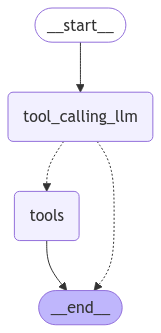

In [50]:
!pip install -q -U langgraph # Install the langgraph package
from IPython.display import Image, display
from langgraph.graph import StateGraph, START,END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.graph.state import CompiledStateGraph

#node
def tool_calling_llm(state: MessagesState)-> MessagesState:
  return {"messages": [llm_with_tools.invoke(state["messages"])]}

#buildgraph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([Multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges (
    "tool_calling_llm",
    #if latest message (resuts) from assistant is a tool call -> tool_condition routs to tool
    #if latest message (resuts) from assistant is not a tool call -> tool_condition routs to END.
    tools_condition,
    )
builder.add_edge("tools", END)

#COMPILE GRAPH
graph: CompiledStateGraph = builder.compile()
# #view
display(Image(graph.get_graph().draw_mermaid_png()))

In [51]:
from pprint import pprint
from langchain_core.messages import HumanMessage, SystemMessage
messages = [HumanMessage(content="hello! can you multiply number")]
messages = graph.invoke({"messages": messages})

pprint(messages)

{'messages': [HumanMessage(content='hello! can you multiply number', additional_kwargs={}, response_metadata={}, id='a9d23f43-c921-446c-99cf-9fdaacf4abd5'),
              AIMessage(content='Yes, I can.  What numbers would you like me to multiply?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-b9b1607b-127e-489e-8530-a627ef1b752c-0', usage_metadata={'input_tokens': 74, 'output_tokens': 16, 'total_tokens': 90, 'input_token_details': {'cache_read': 0}})]}


***Changing prompts***

In [52]:
from pprint import pprint
from langchain_core.messages import HumanMessage, SystemMessage
messages = [HumanMessage(content="hello! multiply 6 and 6")]
messages = graph.invoke({"messages": messages})

pprint(messages)

{'messages': [HumanMessage(content='hello! multiply 6 and 6', additional_kwargs={}, response_metadata={}, id='c80cd75c-4d74-4bb5-bcc5-67615e9ca105'),
              AIMessage(content='', additional_kwargs={'function_call': {'name': 'Multiply', 'arguments': '{"a": 6.0, "b": 6.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-efd8a527-7589-400e-b296-462df16a566c-0', tool_calls=[{'name': 'Multiply', 'args': {'a': 6.0, 'b': 6.0}, 'id': 'ff9b3d10-7bec-478f-895e-c080acf56a1a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 76, 'output_tokens': 3, 'total_tokens': 79, 'input_token_details': {'cache_read': 0}}),
              ToolMessage(content='36', name='Multiply', id='a9e028f5-3a91-4712-a453-4e17b1e00f28', tool_call_id='ff9b3d10-7bec-478f-895e-c080acf56a1a')]}


In [54]:
from pprint import pprint
from langchain_core.messages import HumanMessage, SystemMessage
messages = [HumanMessage(content="can you give me product of 6 and 6 with explination")]
messages = graph.invoke({"messages": messages})

pprint(messages)

{'messages': [HumanMessage(content='can you give me product of 6 and 6 with explination', additional_kwargs={}, response_metadata={}, id='cc9d6c0f-7307-43ef-9bc2-6d7199c0f920'),
              AIMessage(content='', additional_kwargs={'function_call': {'name': 'Multiply', 'arguments': '{"a": 6.0, "b": 6.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-d48599f0-52dd-470e-9f4d-ed166387e27d-0', tool_calls=[{'name': 'Multiply', 'args': {'a': 6.0, 'b': 6.0}, 'id': '1d6e5881-8193-4a0e-bbba-8b982c1bec1e', 'type': 'tool_call'}], usage_metadata={'input_tokens': 83, 'output_tokens': 3, 'total_tokens': 86, 'input_token_details': {'cache_read': 0}}),
              ToolMessage(content='36', name='Multiply', id='6a21dce2-21e5-4163-b0fe-dd8f7f738f69', tool_call_id='1d6e5881-8193-4a0e-bbba-8b982c1bec1e')]}


In [55]:
from pprint import pprint
from langchain_core.messages import HumanMessage, SystemMessage
messages = [HumanMessage(content="what is 6*6")]
messages = graph.invoke({"messages": messages})

pprint(messages)

{'messages': [HumanMessage(content='what is 6*6', additional_kwargs={}, response_metadata={}, id='6eb2354c-a994-4e58-82b0-5037d67dfcd4'),
              AIMessage(content='', additional_kwargs={'function_call': {'name': 'Multiply', 'arguments': '{"a": 6.0, "b": 6.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-b59abfdc-086f-4031-a683-418a2b60ea31-0', tool_calls=[{'name': 'Multiply', 'args': {'a': 6.0, 'b': 6.0}, 'id': '759d1dac-703c-4df5-bb12-f70169bc201d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 74, 'output_tokens': 3, 'total_tokens': 77, 'input_token_details': {'cache_read': 0}}),
              ToolMessage(content='36', name='Multiply', id='c19042dd-c27c-4994-b394-3dfdf8818329', tool_call_id='759d1dac-703c-4df5-bb12-f70169bc201d')]}
